## Import Libraries

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Data Preparation

In [29]:
# Define dataset directories
train_dir = "../Dataset for CA1 part A - AY2526S1/train"
val_dir = "../Dataset for CA1 part A - AY2526S1/validation"
test_dir = "../Dataset for CA1 part A - AY2526S1/test"

In [30]:
# Standardized class mapping
CLASS_MAPPING = {
    # Training set names
    'Bean': 'bean',
    'Bitter_Gourd': 'bitter_gourd',
    'Brinjal': 'brinjal',
    'Cabbage': 'cabbage',
    'Capsicum': 'capsicum',
    'Cauliflower and Broccoli': 'broccoli_cauliflower',
    'Cucumber and Bottle_Gourd': 'bitter_gourd_cucumber',
    'Potato': 'potato',
    'Pumpkin': 'pumpkin',
    'Radish and Carrot': 'carrot_radish',
    'Tomato': 'tomato',

    # Test set names
    'Bottle_Gourd and Cucumber': 'bitter_gourd_cucumber',
    'Broccoli and Cauliflower': 'broccoli_cauliflower',
    'Capsicum (apparently)': 'capsicum',
    'Carrot and Radish': 'carrot_radish',
    'Pumpkin (purportedly)': 'pumpkin',
    'Tomato (ostensibly)': 'tomato',
    
    # Validation set variants
    'Cauliflower with Broccoli': 'broccoli_cauliflower',
    'Cucumber with Bottle_Gourd': 'bitter_gourd_cucumber',
    'Radish with Carrot': 'carrot_radish'
}

In [31]:
def load_dataset(data_dir, target_size):
    """Enhanced dataset loader that:
    1. Handles inconsistent folder names
    2. Converts to grayscale
    3. Resizes images
    4. Normalizes pixel values
    5. Validates class consistency
    """
    # Get actual folder names
    actual_classes = sorted([d.name for d in Path(data_dir).iterdir() if d.is_dir()])
    
    # Map to standardized names
    try:
        standardized_classes = [CLASS_MAPPING[name] for name in actual_classes]
    except KeyError as e:
        raise ValueError(f"Unmapped class folder: {e}. Update CLASS_MAPPING.")

    # Load dataset (using original folder names)
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),
        batch_size=32,
        label_mode='int',
        shuffle=True,
        class_names=actual_classes  # Use original folder names first
    )
    
    # Store standardized names in the dataset object
    dataset.class_names = standardized_classes

    # Enhanced preprocessing
    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, target_size)
        image = image / 255.0  # Normalization
        return image, label

    # Optimize pipeline
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [32]:
# Verify all datasets use consistent classes
def validate_datasets():
    # Load datasets and capture class names
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=(224,224), batch_size=32, shuffle=False)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir, image_size=(224,224), batch_size=32, shuffle=False)
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir, image_size=(224,224), batch_size=32, shuffle=False)
    
    # Get standardized class names
    train_classes = [CLASS_MAPPING[name] for name in train_ds.class_names]
    val_classes = [CLASS_MAPPING[name] for name in val_ds.class_names]
    test_classes = [CLASS_MAPPING[name] for name in test_ds.class_names]
    
    # Verify consistency
    assert set(train_classes) == set(val_classes) == set(test_classes), \
           f"Class mismatch:\nTrain: {train_classes}\nVal: {val_classes}\nTest: {test_classes}"
    print("All datasets have consistent classes:", train_classes)

validate_datasets()

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
All datasets have consistent classes: ['bean', 'bitter_gourd', 'brinjal', 'cabbage', 'capsicum', 'broccoli_cauliflower', 'bitter_gourd_cucumber', 'potato', 'pumpkin', 'carrot_radish', 'tomato']


In [34]:
# Create datasets for both sizes
train_23 = load_dataset(train_dir, (23,23))
val_23 = load_dataset(val_dir, (23,23))
test_23 = load_dataset(test_dir, (23,23))

train_101 = load_dataset(train_dir, (101,101))
val_101 = load_dataset(val_dir, (101,101))
test_101 = load_dataset(test_dir, (101,101))

Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7710 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [35]:
# Verify one sample from each
def inspect_dataset(dataset, name):
    for images, labels in dataset.take(1):
        print(f"\n{name} - Batch info:")
        print("Image shape:", images.shape)
        print("Label shape:", labels.shape)
        print("Pixel range:", (images.numpy().min(), images.numpy().max()))
        if hasattr(dataset, 'class_names'):
            print("Classes:", dataset.class_names)
        else:
            print("Class names not available in dataset object")

inspect_dataset(train_23, "Train 23x23")
inspect_dataset(val_101, "Validation 101x101")


Train 23x23 - Batch info:
Image shape: (32, 23, 23, 1)
Label shape: (32,)
Pixel range: (0.0, 0.98724234)
Class names not available in dataset object

Validation 101x101 - Batch info:
Image shape: (32, 101, 101, 1)
Label shape: (32,)
Pixel range: (0.0, 0.99149334)
Class names not available in dataset object


23x23 Samples:


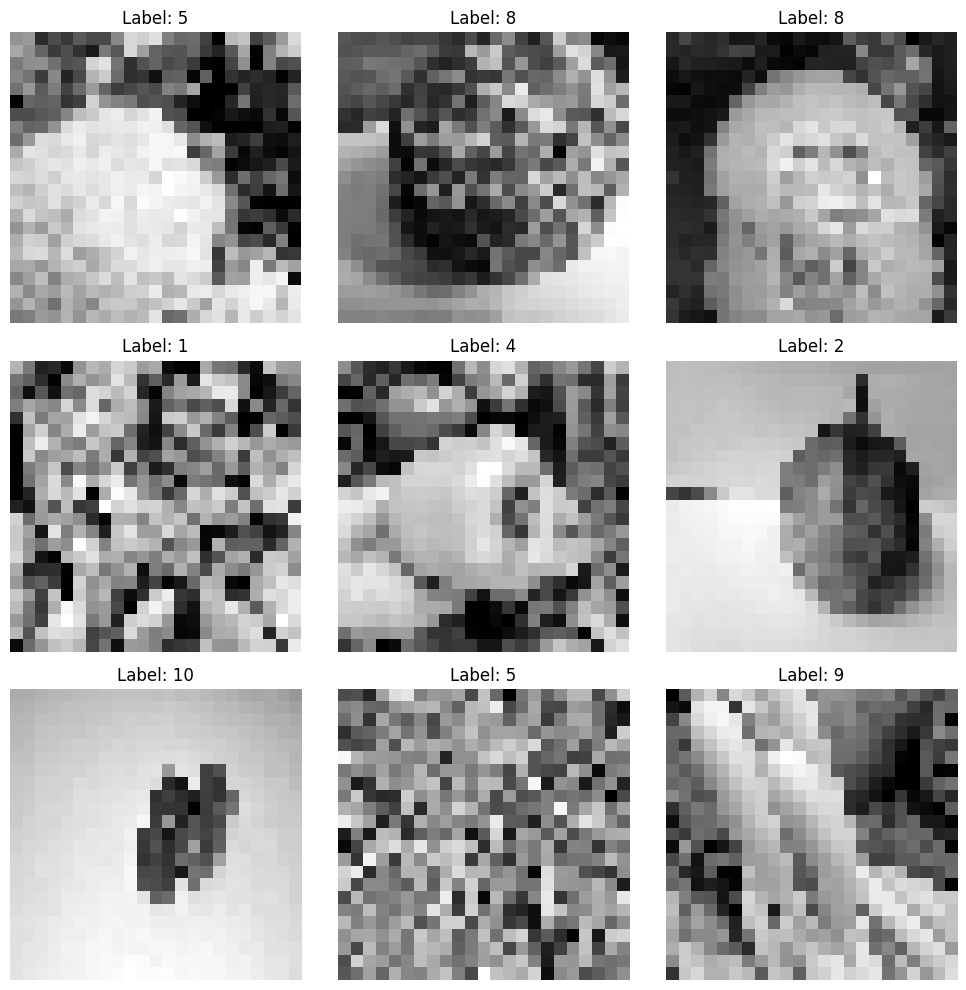


101x101 Samples:


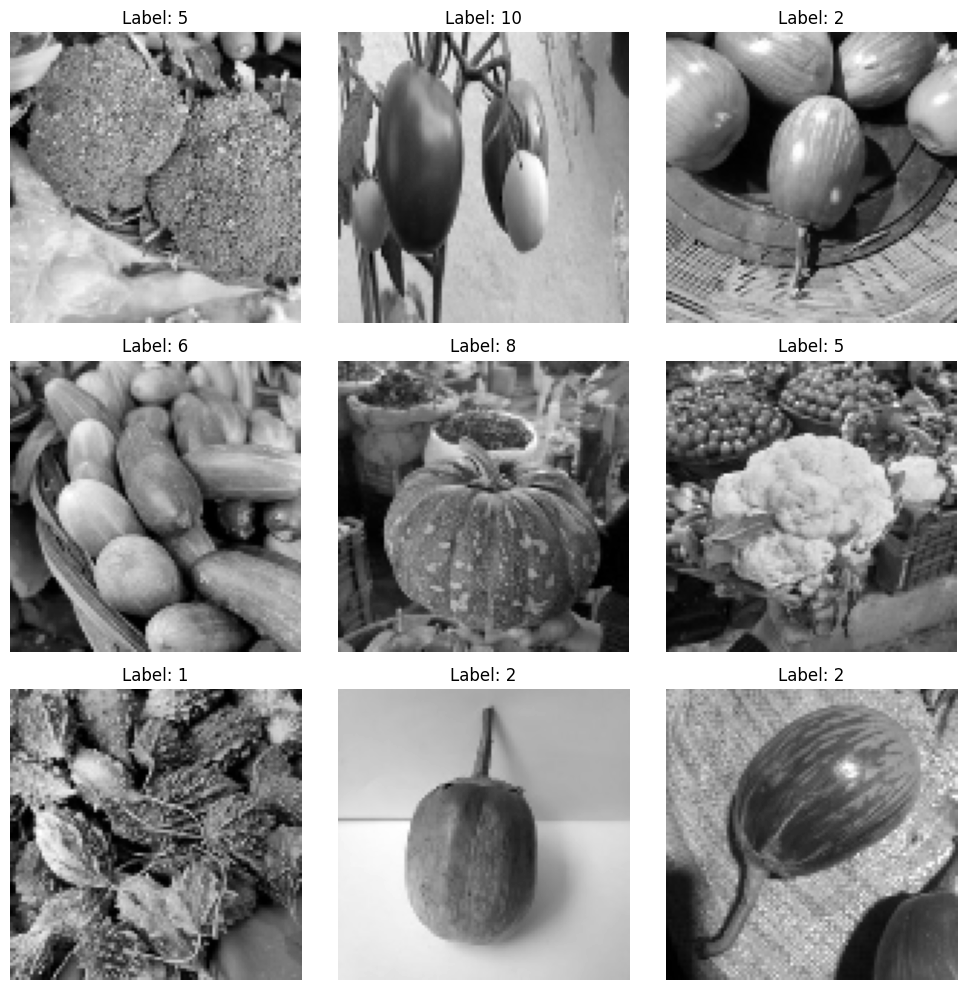

In [36]:
# View the first 9 samples of the training set
def show_samples(dataset, n=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(n, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()


print("23x23 Samples:")
show_samples(train_23)

print("\n101x101 Samples:")
show_samples(train_101)

In [37]:
# Load just the class names without processing images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(train_ds.class_names)  # Original folder names

print("\nStandardized versions:")
print([CLASS_MAPPING[name] for name in train_ds.class_names])

Found 7710 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Brinjal', 'Cabbage', 'Capsicum', 'Cauliflower and Broccoli', 'Cucumber and Bottle_Gourd', 'Potato', 'Pumpkin', 'Radish and Carrot', 'Tomato']

Standardized versions:
['bean', 'bitter_gourd', 'brinjal', 'cabbage', 'capsicum', 'broccoli_cauliflower', 'bitter_gourd_cucumber', 'potato', 'pumpkin', 'carrot_radish', 'tomato']


In [ ]:
# Ensure preprocessing of the dataset was done correctly
def verify_preprocessing(dataset, expected_size):
    batch = next(iter(dataset.take(1)))
    images, _ = batch

    print("\nPreprocessing Verification:")
    print(f"Expected size: {expected_size}")
    print(f"Actual size: {images.shape[1:3]}")
    print(f"Channels: {images.shape[-1]} (1=grayscale)")
    print(f"Normalization check:")
    print(f"Min: {tf.reduce_min(images):.4f}, Max: {tf.reduce_max(images):.4f}")


verify_preprocessing(train_23, (23, 23))
verify_preprocessing(train_101, (101, 101))


Preprocessing Verification:
Expected size: (23, 23)
Actual size: (23, 23)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 0.9999

Preprocessing Verification:
Expected size: (101, 101)
Actual size: (101, 101)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 0.9960


## Fully Connected Model (Baseline)


Training 23x23 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 5s 14ms/step - loss: 2.3884 - accuracy: 0.1191 - val_loss: 2.4030 - val_accuracy: 0.1077
Epoch 2/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3373 - accuracy: 0.1271 - val_loss: 2.4118 - val_accuracy: 0.1309
Epoch 3/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3144 - accuracy: 0.1501 - val_loss: 2.3604 - val_accuracy: 0.1400
Epoch 4/50
241/241 [==============================] - 4s 16ms/step - loss: 2.2921 - accuracy: 0.1619 - val_loss: 2.3643 - val_accuracy: 0.1445
Epoch 5/50
241/241 [==============================] - 4s 16ms/step - loss: 2.2802 - accuracy: 0.1730 - val_loss: 2.3389 - val_accuracy: 0.1491
Epoch 6/50
241/241 [==============================] - 4s 16ms/step - loss: 2.2660 - accuracy: 0.1744 - val_loss: 2.3101 - val_accuracy: 0.1595
Epoch 7/50
241/241 [==============================] - 4s 15ms/step - loss: 2.2425 - accuracy: 0.1861 - val

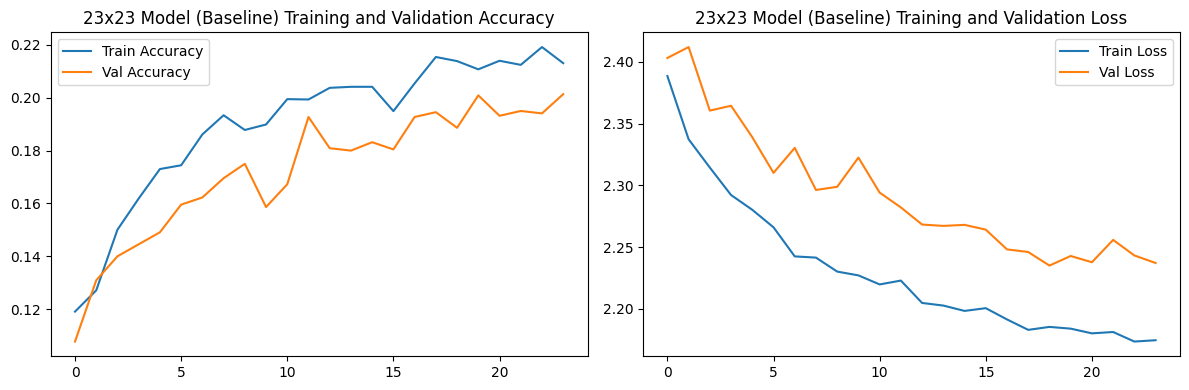

69/69 [==============================] - 1s 11ms/step - loss: 2.5804 - accuracy: 0.1055
23x23 Model (Baseline) - Test Accuracy: 0.1055
23x23 Model (Baseline) - Test Loss: 2.5804

Training 101x101 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 4s 16ms/step - loss: 2.4929 - accuracy: 0.1174 - val_loss: 2.4065 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3594 - accuracy: 0.1220 - val_loss: 2.4253 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3513 - accuracy: 0.1235 - val_loss: 2.4387 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3511 - accuracy: 0.1239 - val_loss: 2.4425 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 4s 15ms/step - loss: 2.3505 - accuracy: 0.1223 - val_loss: 2.4449 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 4s 15ms/step - 

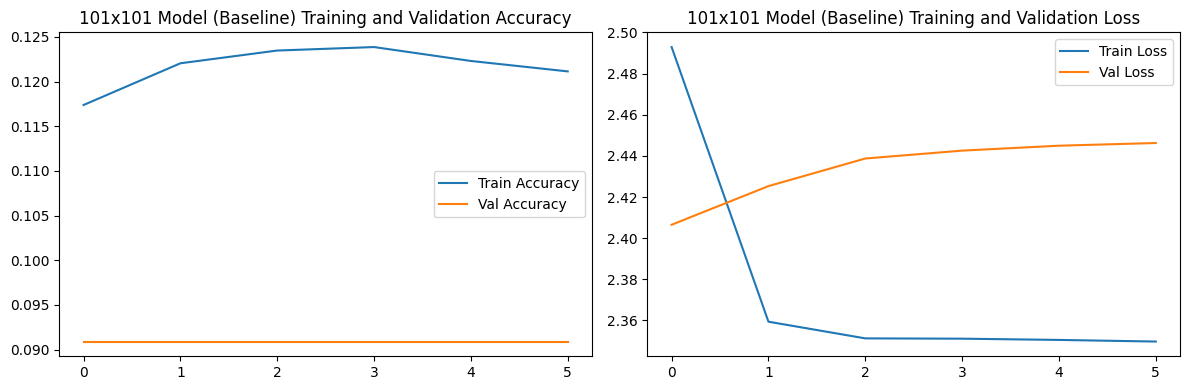

69/69 [==============================] - 1s 11ms/step - loss: 2.4462 - accuracy: 0.0909
101x101 Model (Baseline) - Test Accuracy: 0.0909
101x101 Model (Baseline) - Test Loss: 2.4462


In [ ]:
# Function to create a simple fully connected model (baseline)
def create_fc_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),  # Flatten input to 1D
        layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons
        layers.Dropout(0.5),                      # Dropout layer to prevent overfitting
        layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons
        layers.Dropout(0.5),                      # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'softmax' activation
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the FC model and plot the training history
def train_fc_baseline_model(input_shape, num_classes, train_ds, val_ds, test_ds, model_name, epochs=50):
    # Create the model
    model = create_fc_baseline_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_ds,  # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=epochs,  # Number of epochs
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],  # Early stopping to prevent overfitting
        verbose=1
    )
    
    # Plotting Training History
    plt.figure(figsize=(12, 4))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()
    
    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Evaluate on the test dataset
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")

    return model


# Example usage:

# 23x23 Model (Baseline)
print("\nTraining 23x23 Model (Baseline)...")
input_shape_23 = (23, 23, 1)  # For grayscale images of size 23x23 pixels
num_classes = 11  # 11 classes for classification (vegetables)
fc_baseline_model_23 = train_fc_baseline_model(input_shape_23, num_classes, train_23, val_23, test_23, "23x23 Model (Baseline)")

# 101x101 Model (Baseline)
print("\nTraining 101x101 Model (Baseline)...")
input_shape_101 = (101, 101, 1)  # For grayscale images of size 101x101 pixels
fc_baseline_model_101 = train_fc_baseline_model(input_shape_101, num_classes, train_101, val_101, test_101, "101x101 Model (Baseline)")


## Training CNN Models

In [ ]:
# Create Function to Create the Model with the Following Layers by Passing in the Input Shape
def create_model(input_shape):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(11, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
# Define Function to train the CNN Model
def train_model(model, train_ds, val_ds, model_name):
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5)
    checkpoint = callbacks.ModelCheckpoint(
        f"best_{model_name}.h5", save_best_only=True, monitor="val_accuracy"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping, checkpoint],
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training.png")
    plt.show()

    return model

Training 23x23 model...
Epoch 1/50
241/241 [==============================] - 8s 17ms/step - loss: 2.2512 - accuracy: 0.1792 - val_loss: 2.0794 - val_accuracy: 0.2805
Epoch 2/50
241/241 [==============================] - 4s 16ms/step - loss: 1.9332 - accuracy: 0.3350 - val_loss: 1.8360 - val_accuracy: 0.3859
Epoch 3/50
241/241 [==============================] - 4s 16ms/step - loss: 1.7015 - accuracy: 0.4271 - val_loss: 1.5362 - val_accuracy: 0.4986
Epoch 4/50
241/241 [==============================] - 4s 16ms/step - loss: 1.5105 - accuracy: 0.4949 - val_loss: 1.3676 - val_accuracy: 0.5505
Epoch 5/50
241/241 [==============================] - 4s 16ms/step - loss: 1.3286 - accuracy: 0.5590 - val_loss: 1.2015 - val_accuracy: 0.6032
Epoch 6/50
241/241 [==============================] - 4s 16ms/step - loss: 1.1936 - accuracy: 0.6043 - val_loss: 1.2047 - val_accuracy: 0.5941
Epoch 7/50
241/241 [==============================] - 4s 16ms/step - loss: 1.0731 - accuracy: 0.6460 - val_loss: 0.975

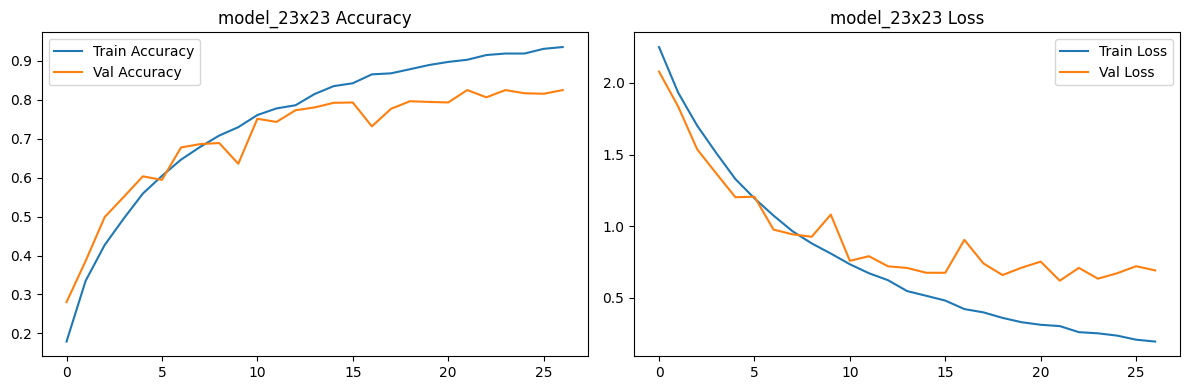


Training 101x101 model...
Epoch 1/50
241/241 [==============================] - 6s 22ms/step - loss: 2.0980 - accuracy: 0.2497 - val_loss: 1.6928 - val_accuracy: 0.4532
Epoch 2/50
241/241 [==============================] - 5s 20ms/step - loss: 1.6479 - accuracy: 0.4246 - val_loss: 1.2603 - val_accuracy: 0.6027
Epoch 3/50
241/241 [==============================] - 5s 20ms/step - loss: 1.3426 - accuracy: 0.5420 - val_loss: 1.1308 - val_accuracy: 0.6300
Epoch 4/50
241/241 [==============================] - 5s 20ms/step - loss: 1.1552 - accuracy: 0.6115 - val_loss: 0.8902 - val_accuracy: 0.7164
Epoch 5/50
241/241 [==============================] - 5s 21ms/step - loss: 0.9846 - accuracy: 0.6564 - val_loss: 0.8794 - val_accuracy: 0.7245
Epoch 6/50
241/241 [==============================] - 5s 20ms/step - loss: 0.8513 - accuracy: 0.7114 - val_loss: 0.8269 - val_accuracy: 0.7468
Epoch 7/50
241/241 [==============================] - 5s 21ms/step - loss: 0.7381 - accuracy: 0.7407 - val_loss: 0.

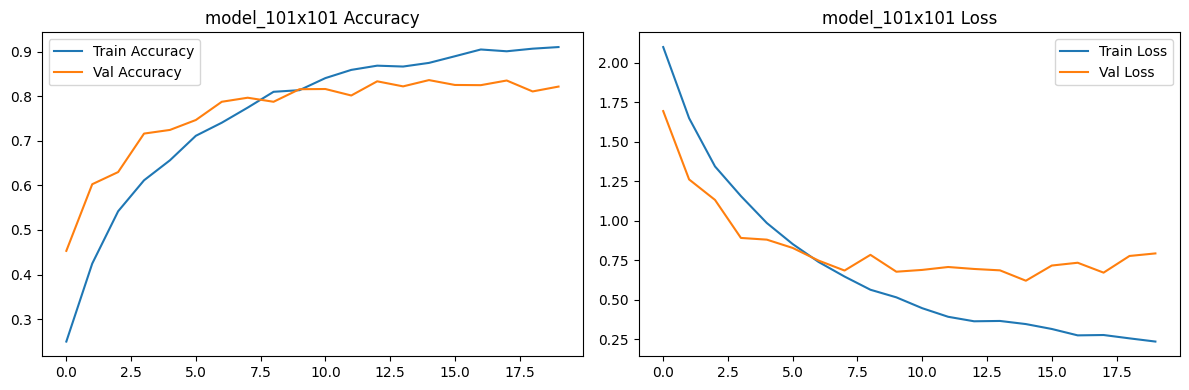

In [ ]:
# Train the Models for the 2 different Input Sizes
print("Training 23x23 model...")
model_23 = create_model((23, 23, 1))
train_model(model_23, train_23, val_23, "model_23x23")

print("\nTraining 101x101 model...")
model_101 = create_model((101, 101, 1))
train_model(model_101, train_101, val_101, "model_101x101")

In [ ]:
# Evaluate the model's Performance using the Test Dataset
# Evaluation with basic metrics
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy


# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 9.3820
Test Accuracy: 0.1723
Error Rate: 0.8277

Evaluating 101x101 Model:
Test Loss: 13.6029
Test Accuracy: 0.1777
Error Rate: 0.8223

Accuracy Improvement: 0.0055
Loss Reduction: -4.2209


## Improving the CNN Models

In [ ]:
def create_improved_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def train_improved_model(model, train_ds, val_ds, model_name, epochs=50):
    """
    Training function with EarlyStopping and ModelCheckpoint for improved models.
    """
    print(f"\nTraining {model_name} (Improved) model...")

    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    checkpoint = callbacks.ModelCheckpoint(
        f"best_{model_name}_improved.h5", save_best_only=True, monitor="val_accuracy"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy (Improved)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss (Improved)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_improved.png")
    plt.show()

    return model



Training model_23x23 (Improved) model...
Epoch 1/50
241/241 [==============================] - 5s 18ms/step - loss: 1.7846 - accuracy: 0.3996 - val_loss: 3.3773 - val_accuracy: 0.0918
Epoch 2/50
241/241 [==============================] - 4s 17ms/step - loss: 1.2583 - accuracy: 0.5813 - val_loss: 2.4691 - val_accuracy: 0.2527
Epoch 3/50
241/241 [==============================] - 4s 17ms/step - loss: 0.9771 - accuracy: 0.6763 - val_loss: 2.0710 - val_accuracy: 0.4741
Epoch 4/50
241/241 [==============================] - 4s 17ms/step - loss: 0.7799 - accuracy: 0.7389 - val_loss: 1.0941 - val_accuracy: 0.6377
Epoch 5/50
241/241 [==============================] - 4s 17ms/step - loss: 0.6534 - accuracy: 0.7935 - val_loss: 3.6574 - val_accuracy: 0.3755
Epoch 6/50
241/241 [==============================] - 4s 17ms/step - loss: 0.5372 - accuracy: 0.8246 - val_loss: 1.7747 - val_accuracy: 0.5509
Epoch 7/50
241/241 [==============================] - 4s 17ms/step - loss: 0.4511 - accuracy: 0.8507

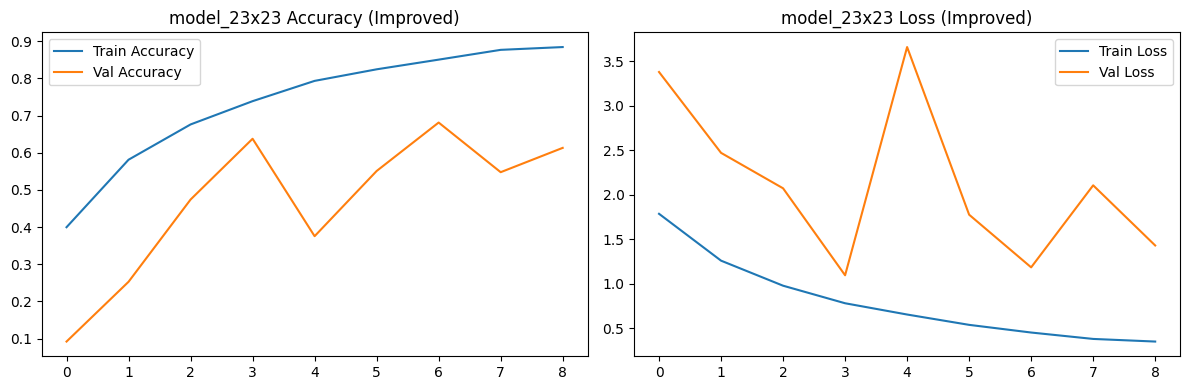


Training model_101x101 (Improved) model...
Epoch 1/50
241/241 [==============================] - 6s 21ms/step - loss: 1.6265 - accuracy: 0.4515 - val_loss: 4.8179 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 5s 21ms/step - loss: 1.0514 - accuracy: 0.6615 - val_loss: 3.8726 - val_accuracy: 0.1586
Epoch 3/50
241/241 [==============================] - 5s 21ms/step - loss: 0.7477 - accuracy: 0.7619 - val_loss: 1.6276 - val_accuracy: 0.5327
Epoch 4/50
241/241 [==============================] - 5s 20ms/step - loss: 0.5758 - accuracy: 0.8257 - val_loss: 1.8420 - val_accuracy: 0.4850
Epoch 5/50
241/241 [==============================] - 5s 20ms/step - loss: 0.4557 - accuracy: 0.8589 - val_loss: 2.4558 - val_accuracy: 0.4473
Epoch 6/50
241/241 [==============================] - 5s 20ms/step - loss: 0.3911 - accuracy: 0.8787 - val_loss: 1.2774 - val_accuracy: 0.6686
Epoch 7/50
241/241 [==============================] - 5s 20ms/step - loss: 0.3217 - accuracy: 0.89

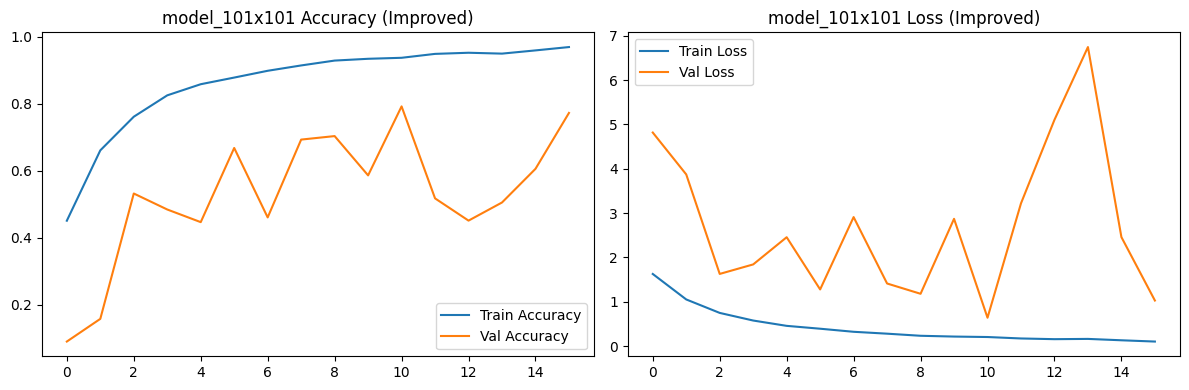

In [ ]:
# Create improved models
improved_model_23 = create_improved_model((23, 23, 1))
improved_model_101 = create_improved_model((101, 101, 1))

# Train improved models
improved_model_23 = train_improved_model(improved_model_23, train_23, val_23, "model_23x23")
improved_model_101 = train_improved_model(improved_model_101, train_101, val_101, "model_101x101")


In [ ]:
# Evaluate the improved model's performance using the test dataset
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy


# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")



Evaluating 23x23 Model (Improved):
Test Loss: 5.1353
Test Accuracy: 0.1127
Error Rate: 0.8873

Evaluating 101x101 Model (Improved):
Test Loss: 8.9885
Test Accuracy: 0.1382
Error Rate: 0.8618

Accuracy Improvement (101x101 - 23x23): 0.0255
Loss Reduction (23x23 - 101x101): -3.8533


## Implement Hyperparameter Tuning for the 23x23 Model

In [ ]:
import keras_tuner as kt

# Define the model-building function for Keras Tuner
def build_model_with_hyperparameters(hp):
    model = models.Sequential()
    
    # Conv Layer 1
    model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(23, 23, 1)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    model.add(layers.BatchNormalization())
    
    model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=30,
    directory='kt_dir',
    project_name='improved_model_tuning'
)



Reloading Tuner from kt_dir\improved_model_tuning\tuner0.json


In [ ]:
# Run hyperparameter tuning
tuner.search(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


Best Hyperparameters: {'conv_1_filters': 96, 'conv_2_filters': 256, 'conv_3_filters': 512, 'dense_units': 128, 'dropout_rate': 0.3, 'learning_rate': 7.285461811915875e-05}


In [ ]:
# Build and train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)


Epoch 1/50
241/241 [==============================] - 5s 19ms/step - loss: 1.7635 - accuracy: 0.4126 - val_loss: 2.8930 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 5s 18ms/step - loss: 1.1979 - accuracy: 0.6214 - val_loss: 2.4044 - val_accuracy: 0.2686
Epoch 3/50
241/241 [==============================] - 4s 18ms/step - loss: 0.9226 - accuracy: 0.7156 - val_loss: 0.9813 - val_accuracy: 0.7168
Epoch 4/50
241/241 [==============================] - 5s 18ms/step - loss: 0.7257 - accuracy: 0.7838 - val_loss: 0.8253 - val_accuracy: 0.7291
Epoch 5/50
241/241 [==============================] - 4s 18ms/step - loss: 0.5806 - accuracy: 0.8390 - val_loss: 0.7054 - val_accuracy: 0.7805
Epoch 6/50
241/241 [==============================] - 4s 18ms/step - loss: 0.4724 - accuracy: 0.8703 - val_loss: 0.7040 - val_accuracy: 0.7795
Epoch 7/50
241/241 [==============================] - 4s 18ms/step - loss: 0.3766 - accuracy: 0.9061 - val_loss: 0.6207 - val_accuracy: 0.8091

In [ ]:
# Evaluate the best model
test_loss, test_acc = best_model.evaluate(test_23)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


69/69 [==============================] - 1s 11ms/step - loss: 6.0629 - accuracy: 0.1955
Test Accuracy: 0.1955
Test Loss: 6.0629


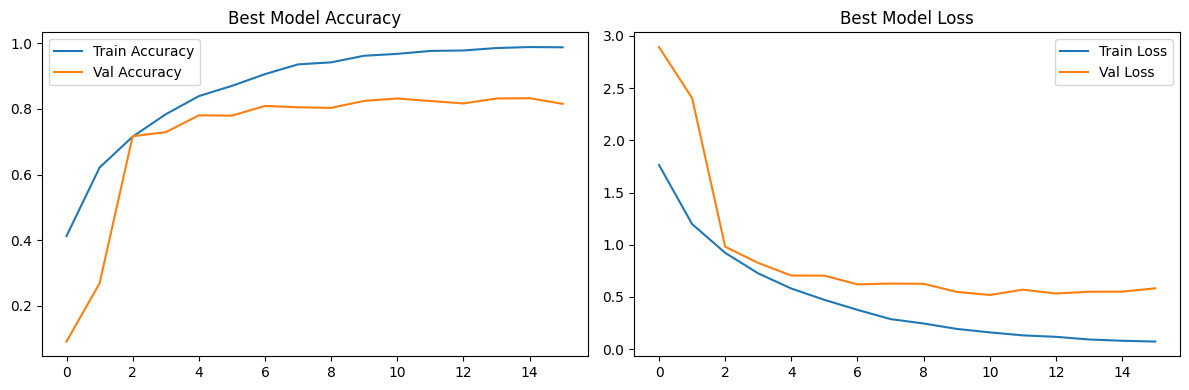

In [ ]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title(f"Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"Best Model Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Implement Hyperparameter Tuning for the 101x101 Model